<a href="https://colab.research.google.com/github/bennigeir/praat-speech-analysis/blob/main/praat_speech_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
# import libraries

import pandas as pd
import random
import numpy as np
from sklearn import svm
import scipy
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
def is_outlier(s):
    lower_limit = s.mean() - (s.std() * 3)
    upper_limit = s.mean() + (s.std() * 3)
    return ~s.between(lower_limit, upper_limit)

In [16]:
# read csv file
df = pd.read_csv('icelandic_vowels_f1_f2.csv')

# remove word kýr
df = df[df.word != 'kýr']

# create boolean column for native icelandic speaker
df['native_isl'] = np.where(df['native_lang']=='isl', 'isl', 'not_isl')

# remove outliers
df = df[~df.groupby(by='word')['F1'].apply(is_outlier)]
df = df[~df.groupby(by='word')['F2'].apply(is_outlier)]

# reset index
df.reset_index(inplace=True)

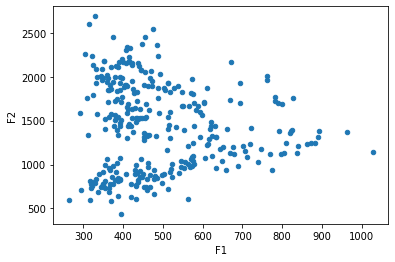

In [17]:
# sanity check: plot all points

df.plot.scatter(x="F1", y="F2")

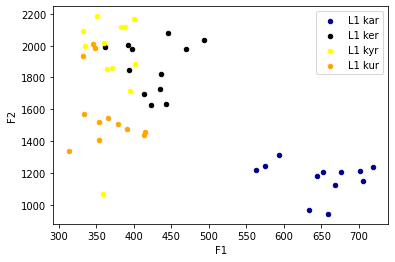

In [18]:
# plot a few specific words

ax = df.query('word == "kar" & native_lang == "isl"').plot.scatter(x="F1", y="F2", color="DarkBlue", label="L1 kar")
#df.query('word == "kar" & native_lang != "isl"').plot.scatter(x="F1", y="F2", color="DarkGreen", label="L2 kar", ax=ax)

df.query('word == "ker" & native_lang == "isl"').plot.scatter(x="F1", y="F2", color="Black", label="L1 ker", ax=ax)
#df.query('word == "ker" & native_lang != "isl"').plot.scatter(x="F1", y="F2", color="LightGreen", label="L2 ker", ax=ax)

df.query('word == "kyr" & native_lang == "isl"').plot.scatter(x="F1", y="F2", color="Yellow", label="L1 kyr", ax=ax)
#df.query('word == "kyr" & native_lang != "isl"').plot.scatter(x="F1", y="F2", color="Red", label="L2 kyr", ax=ax)

df.query('word == "kur" & native_lang == "isl"').plot.scatter(x="F1", y="F2", color="Orange", label="L1 kur", ax=ax)
#df.query('word == "kur" & native_lang != "isl"').plot.scatter(x="F1", y="F2", color="Pink", label="L2 kur", ax=ax)

In [19]:
# function taken from matplotlib manual (https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html)

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

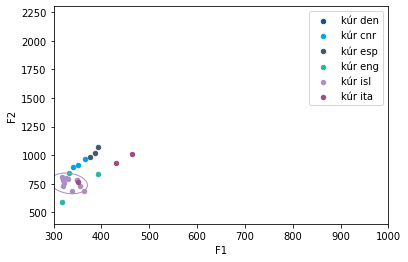

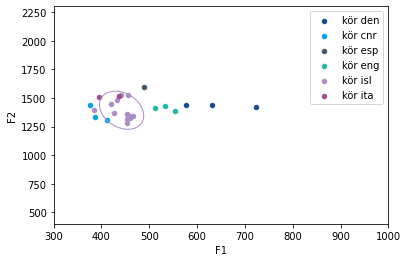

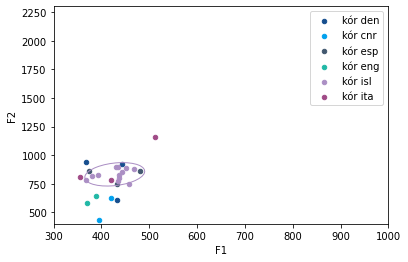

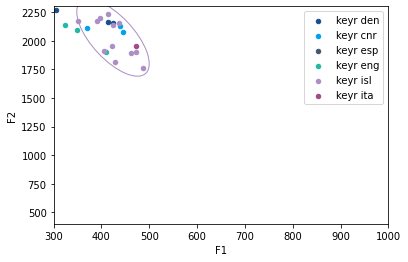

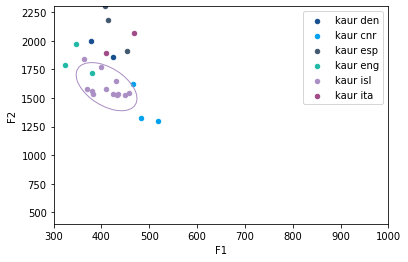

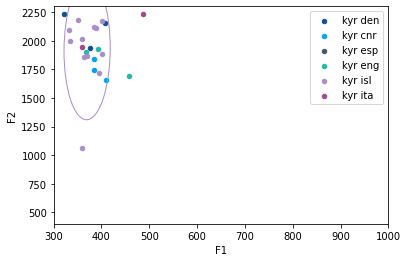

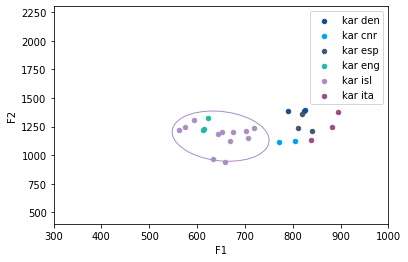

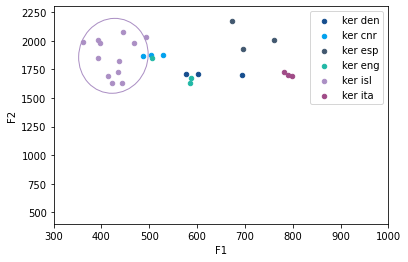

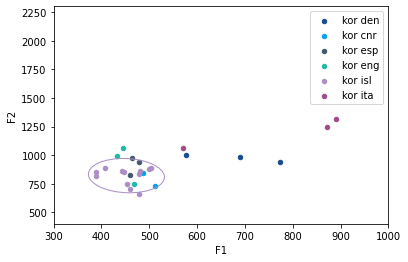

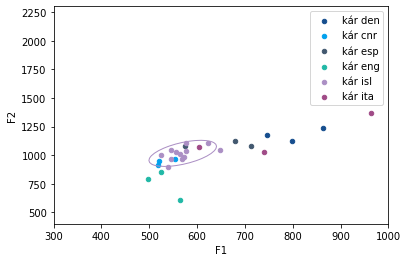

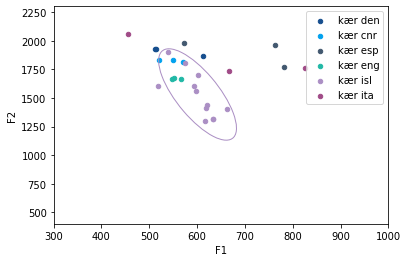

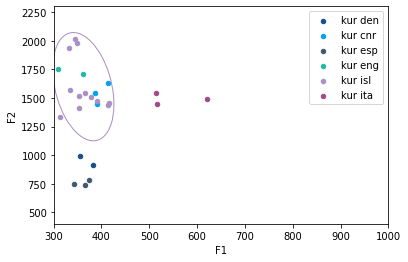

In [27]:
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (300, 1000)
custom_ylim = (400, 2300)

colors = {}
for native_lang in set(df.native_lang):
    random_color = (random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1))
    colors[native_lang] = random_color

with PdfPages('multipage_pdf.pdf') as pdf:
    for i, word in enumerate(set(df.word)):
#        fig = plt.figure()
        first = True
        for native_lang in set(df.native_lang):
            color = colors[native_lang]
            if first == True:
                ax =  df.query("word == '{}' & native_lang == '{}'".format(word, native_lang)).plot.scatter(x="F1", y="F2", color=color, label="{} {}".format(word, native_lang), xlim=custom_xlim, ylim=custom_ylim)
                x = df[(df.native_lang == 'isl') & (df.word == word)]['F1']
                y = df[(df.native_lang == 'isl') & (df.word == word)]['F2']
                confidence_ellipse(x, y, ax, edgecolor=colors['isl'], n_std=2)
                first = False
            else:
                df.query("word == '{}' & native_lang == '{}'".format(word, native_lang)).plot.scatter(x="F1", y="F2", color=color, label="{} {}".format(word, native_lang), ax=ax, xlim=custom_xlim, ylim=custom_ylim)
#        pdf.savefig(fig)
#        plt.close()

In [204]:
#### TESTING dialect classification on one word at a time ### Randomly splitting test and training

# read csv file
df = pd.read_csv('icelandic_vowels_f1_f2.csv')

# remove word kýr
df = df[df.word != 'kýr']

# create boolean column for native icelandic speaker
df['native_isl'] = np.where(df['native_lang']=='isl', 'isl', 'not_isl')

# remove outliers
df = df[~df.groupby(by='word')['F1'].apply(is_outlier)]
df = df[~df.groupby(by='word')['F2'].apply(is_outlier)]

# reset index
df.reset_index(inplace=True)

# set Y
Y = df['native_isl']

# set X
    # one-hot encode the words
X = pd.get_dummies(df[['word']]).join(df)

# define classification model
clf = svm.SVC()
clf2 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1, max_iter=200)
clf3 = KNeighborsClassifier()

# define data splitting method
kf = KFold(n_splits=2, random_state=10, shuffle=True)
kf.get_n_splits(X)
print(kf)

scores = []
augmented_scores = []
scores2 = []
augmented_scores2 = []
scores3 = []
augmented_scores3 = []
for train_index, test_index in kf.split(X):
    # split data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    X_train = X_train.drop(columns=['name', 'age', 'native_lang', 'spoken_lang', 'word', 'native_isl'])
    X_test = X_test.drop(columns=['name', 'age', 'native_lang', 'spoken_lang', 'word', 'native_isl'])

    # augment data (very simple augmentation method)
    training = X_train.join(Y_train.to_frame())
    augment_training = training.copy(deep=True)
    for i in range(-10,10):
        augmentation = training.copy(deep=True)
        augmentation[['F1', 'F2']] += i
        augment_training = pd.concat([augment_training, augmentation])

    augmented_X_train = augment_training.drop(columns=['native_isl'])
    augmented_Y_train = augment_training[['native_isl']].values.ravel()

    # scale data
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_train = scaler.fit_transform(X_train)
    augmented_X_train = scaler.fit_transform(augmented_X_train)
    X_test = scaler.fit_transform(X_test)

    # # run model
    # scores.append(clf.fit(X_train, Y_train).score(X_test, Y_test))
    # augmented_scores.append(clf.fit(augmented_X_train, augmented_Y_train).score(X_test, Y_test))
    # scores2.append(clf2.fit(X_train, Y_train).score(X_test, Y_test))
    # augmented_scores2.append(clf2.fit(augmented_X_train, augmented_Y_train).score(X_test, Y_test))
    scores3.append(clf3.fit(X_train, Y_train).score(X_test, Y_test))
    augmented_scores3.append(clf3.fit(augmented_X_train, augmented_Y_train).score(X_test, Y_test))
    preds = clf3.predict(X_test)
    word_scores = {}
    for x, pred, actual in zip(X_test, preds, Y_test):
        word = X.columns[np.argmax(x)]
        if word in word_scores:
            word_scores[word]['total'] += 1
        else:
            word_scores[word] = {}
            word_scores[word]['total'] = 1
            word_scores[word]['correct'] = 0
        if pred == actual:
            word_scores[word]['correct'] += 1

    for word in word_scores:
        print(word, word_scores[word]['correct'] / word_scores[word]['total'])

# print('SVC scores:', scores)
# print('SVC scores augmented:', augmented_scores)
# print('MLPClassifier scores:', scores2)
# print('MLPClassifier scores augmented:', augmented_scores2)
print('KNeighboursClassifier scores: ', scores3)
print('KNeighboursClassifier scores augmented: ', augmented_scores3)

KFold(n_splits=2, random_state=10, shuffle=True)
word_kar 0.7692307692307693
word_ker 1.0
word_kyr 0.6
word_kor 0.75
word_kör 0.5833333333333334
word_kár 0.7647058823529411
word_kær 0.5
word_keyr 0.6
word_kór 0.9090909090909091
word_kaur 0.7647058823529411
word_kur 1.0
word_kúr 0.75
word_ker 0.8125
word_kyr 0.6363636363636364
word_kor 0.7142857142857143
word_kur 0.6875
word_kúr 0.75
word_kör 0.75
word_kár 0.9
word_keyr 0.6666666666666666
word_kór 0.6666666666666666
word_kaur 1.0
word_kær 0.6
word_kar 0.6428571428571429
KNeighboursClassifier scores:  [0.4713375796178344, 0.48717948717948717]
KNeighboursClassifier scores augmented:  [0.7388535031847133, 0.7243589743589743]


In [206]:
#### TESTING dialect classification on one word at a time ### splitting test and training by person

# read csv file
df = pd.read_csv('icelandic_vowels_f1_f2.csv')

# remove word kýr
df = df[df.word != 'kýr']

# create boolean column for native icelandic speaker
df['native_isl'] = np.where(df['native_lang']=='isl', 'isl', 'not_isl')

# remove outliers
df = df[~df.groupby(by='word')['F1'].apply(is_outlier)]
df = df[~df.groupby(by='word')['F2'].apply(is_outlier)]

# reset index
df.reset_index(inplace=True)

# define classification model
clf = svm.SVC()
clf2 = MLPClassifier()
clf3 = KNeighborsClassifier()

# one-hot encode the words
df = pd.get_dummies(df[['word']]).join(df)

# make training test splits:
for name in set(df['name']):

    training = df[df.name!=name]
    test = df[df.name==name]

    # set Y
    Y_train = training['native_isl']
    Y_test = test['native_isl']

    # set X
    X_train = training.drop(columns=['name', 'age', 'native_lang', 'spoken_lang', 'word', 'native_isl'])
    X_test = test.drop(columns=['name', 'age', 'native_lang', 'spoken_lang', 'word', 'native_isl'])


    # augment data (very simple augmentation method)
    training = X_train.join(Y_train.to_frame())
    augment_training = training.copy(deep=True)
    for i in range(-10,10):
        augmentation = training.copy(deep=True)
        augmentation[['F1', 'F2']] += i
        augment_training = pd.concat([augment_training, augmentation])

    augmented_X_train = augment_training.drop(columns=['native_isl'])
    augmented_Y_train = augment_training[['native_isl']].values.ravel()

    # scale data
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_train = scaler.fit_transform(X_train)
    augmented_X_train = scaler.fit_transform(augmented_X_train)
    X_test = scaler.fit_transform(X_test)

    # # run model
    # score = clf.fit(X_train, Y_train).score(X_test, Y_test)
    # augmented_score = clf.fit(augmented_X_train, augmented_Y_train).score(X_test, Y_test)
    # score2 = clf2.fit(X_train, Y_train).score(X_test, Y_test)
    # augmented_score2 = clf2.fit(augmented_X_train, augmented_Y_train).score(X_test, Y_test)

    score3 = clf3.fit(X_train, Y_train).score(X_test, Y_test)
    augmented_score3 = clf3.fit(augmented_X_train, augmented_Y_train).score(X_test, Y_test)
    # preds = clf3.predict(X_test)
    # word_scores = {}
    # for x, pred, actual in zip(X_test, preds, Y_test):
    #     word = X.columns[np.argmax(x)]
    #     if word in word_scores:
    #         word_scores[word]['total'] += 1
    #     else:
    #         word_scores[word] = {}
    #         word_scores[word]['total'] = 1
    #         word_scores[word]['correct'] = 0
    #     if pred == actual:
    #         word_scores[word]['correct'] += 1

    # for word in word_scores:
    #     print(word, word_scores[word]['correct'] / word_scores[word]['total'])

    # print('SVC scores:', scores)
    # print('SVC scores augmented:', augmented_scores)
    # print('MLPClassifier scores:', scores2)
    # print('MLPClassifier scores augmented:', augmented_scores2)

    print(name, score3, augmented_score3)

# print('KNeighboursClassifier scores: ', scores3)
# print('KNeighboursClassifier scores augmented: ', augmented_scores3)

it 0.4411764705882353 0.5588235294117647
b 0.5277777777777778 0.3333333333333333
de 0.7096774193548387 0.9032258064516129
d 0.5405405405405406 0.3783783783783784
m 0.47058823529411764 0.5294117647058824
st 0.4166666666666667 0.3611111111111111
a 0.4166666666666667 0.25
r 0.3235294117647059 0.6176470588235294
l 0.6857142857142857 0.8


b 0.8055555555555556
Classification report for classifier SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False):
              precision    recall  f1-score   support

         kar       0.60      1.00      0.75         3
        kaur       0.75      1.00      0.86         3
         ker       0.50      0.33      0.40         3
        keyr       1.00      1.00      1.00         3
         kor       1.00      1.00      1.00         3
         kur       1.00      0.33      0.50         3
         kyr       1.00      0.67      0.80         3
         kár       1.00      0.33      0.50         3
         kær       0.75      1.00      0.86         3
         kór       1.00      1.00      1.00         3
         kör       0.60      1.00      0.75         3
         kúr       1.00      1.00      1.0

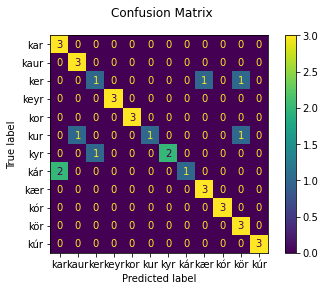

d 0.7777777777777778
Classification report for classifier SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False):
              precision    recall  f1-score   support

         kar       1.00      1.00      1.00         3
        kaur       0.67      0.67      0.67         3
         ker       0.50      1.00      0.67         3
        keyr       1.00      1.00      1.00         3
         kor       1.00      1.00      1.00         3
         kur       0.00      0.00      0.00         3
         kyr       0.00      0.00      0.00         3
         kár       1.00      1.00      1.00         3
         kær       1.00      1.00      1.00         3
         kór       1.00      1.00      1.00         3
         kör       1.00      0.67      0.80         3
         kúr       1.00      1.00      1.0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


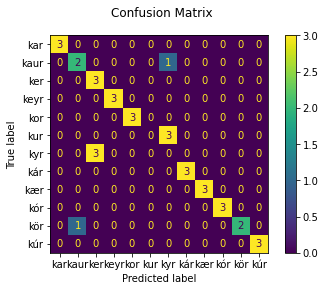

a 0.7222222222222222
Classification report for classifier SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False):
              precision    recall  f1-score   support

         kar       0.38      1.00      0.55         3
        kaur       1.00      1.00      1.00         3
         ker       0.00      0.00      0.00         3
        keyr       1.00      0.67      0.80         3
         kor       1.00      1.00      1.00         3
         kur       1.00      1.00      1.00         3
         kyr       0.33      0.67      0.44         3
         kár       0.00      0.00      0.00         3
         kær       1.00      0.33      0.50         3
         kór       1.00      1.00      1.00         3
         kör       1.00      1.00      1.00         3
         kúr       0.75      1.00      0.8

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


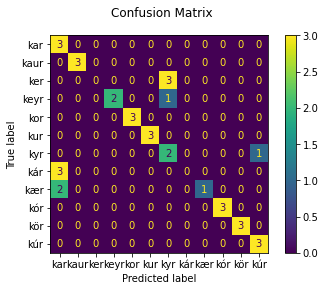

st 0.8888888888888888
Classification report for classifier SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False):
              precision    recall  f1-score   support

         kar       1.00      1.00      1.00         3
        kaur       0.60      1.00      0.75         3
         ker       1.00      0.33      0.50         3
        keyr       1.00      1.00      1.00         3
         kor       1.00      1.00      1.00         3
         kur       1.00      0.33      0.50         3
         kyr       0.60      1.00      0.75         3
         kár       1.00      1.00      1.00         3
         kær       1.00      1.00      1.00         3
         kór       1.00      1.00      1.00         3
         kör       1.00      1.00      1.00         3
         kúr       1.00      1.00      1.

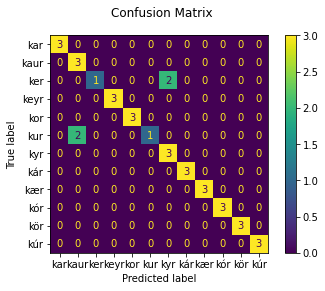

In [5]:
#### TESTING vowel classification on native icelandic pronunciations ### splitting test and training by person

# read csv file
df = pd.read_csv('icelandic_vowels_f1_f2.csv')

# remove word kýr
df = df[df.word != 'kýr']

# remove L2 speakers
df = df[df.native_lang == 'isl']

# remove outliers
df = df[~df.groupby(by='word')['F1'].apply(is_outlier)]
df = df[~df.groupby(by='word')['F2'].apply(is_outlier)]

# reset index
df.reset_index(inplace=True)

# define classification model # Using non-linear, since data appears non-linear
clf = svm.SVC()
a_clf = svm.SVC()
clf2 = MLPClassifier()
a_clf2 = MLPClassifier()
clf3 = KNeighborsClassifier()
a_clf3 = KNeighborsClassifier()
clf4 = svm.NuSVC()
clf5 = DecisionTreeClassifier()

# make training test splits:
for name in set(df['name']):

    training = df[df.name!=name]
    test = df[df.name==name]

    # set Y
    Y_train = training['word']
    Y_test = test['word']

    # set X
    X_train = training.drop(columns=['name', 'age', 'native_lang', 'spoken_lang', 'word'])
    X_test = test.drop(columns=['name', 'age', 'native_lang', 'spoken_lang', 'word'])


    # augment data (very simple augmentation method)
    training = X_train.join(Y_train.to_frame())
    augment_training = training.copy(deep=True)
    for i in range(-10,10):
        augmentation = training.copy(deep=True)
        augmentation[['F1', 'F2']] += i
        augment_training = pd.concat([augment_training, augmentation])

    augmented_X_train = augment_training.drop(columns=['word'])
    augmented_Y_train = augment_training[['word']].values.ravel()

    # scale data
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_train = scaler.fit_transform(X_train)
    augmented_X_train = scaler.fit_transform(augmented_X_train)
    X_test = scaler.fit_transform(X_test)

    # # run model
    score = clf.fit(X_train, Y_train).score(X_test, Y_test)
    Y_pred = clf.predict(X_test)
    # a_score = a_clf.fit(augmented_X_train, augmented_Y_train).score(X_test, Y_test)
    # score2 = clf2.fit(X_train, Y_train).score(X_test, Y_test)
    # a_score2 = a_clf2.fit(augmented_X_train, augmented_Y_train).score(X_test, Y_test)
    # score3 = clf3.fit(X_train, Y_train).score(X_test, Y_test)
    # predicted3 = clf3.predict(X_test)
    # a_score3 = a_clf3.fit(augmented_X_train, augmented_Y_train).score(X_test, Y_test)
    # a_predicted3 = a_clf3.predict(X_test)
    # score4 = clf4.fit(X_train, Y_train).score(X_test, Y_test)
    # score5 = clf5.fit(X_train, Y_train).score(X_test, Y_test)

    print(name, score)

    print(f"Classification report for classifier {clf}:\n"
      f"{classification_report(Y_test, Y_pred)}\n")
    
    disp = plot_confusion_matrix(clf, X_test, Y_test)
    disp.figure_.suptitle("Confusion Matrix")
    print(f"Confusion matrix:\n{disp.confusion_matrix}")

    plt.show()

    # print(name, score, a_score, score2, a_score2, score3, a_score3, score4)

# print('KNeighboursClassifier scores: ', scores3)
# print('KNeighboursClassifier scores augmented: ', augmented_scores3)